# Data Challenge Description

The file data.csv contains several columns of information for your analysis. The data are synthetic but were constructed to mimic data that we observe from real-world satellite images.

The car.count column shows the number of cars observed in a parking lot for a retail location like a WalMart or Home Depot. The weather and cloud.indicator columns tell something about whether the parking lot was visible each day.

We would like you to do some exploration of the data, fit some simple models, and summarize what you find, with the goal of both describing the data included and being able to forecast future values. We have in mind this should take no more than a couple of hours.

We are interested to know what you find, but also how you go about finding it. What process? What methods? What intuitions did you use to guide your investigation? Why did you do "this" or "that."

*Please produce some output including plots and other results to explain what you find and how you did it. Don't worry too much about making the output and plots pretty -- well organized is good enough.

Please use any analysis tools and methods that you wish for this project as long as you can explain what each is doing and why you chose to use it. 


Some example questions to answer:

1) Summarize in a qualitative way what you see in the data when you first look it over. What does this suggest for your "plan of attack" for your analysis? What techniques might be appropriate and useful?

2) How would you characterize your findings quantitatively?

3) What additional analysis might be useful if you had a whole day to work on the problem?




Our team will review your work and get back to you. We may ask to schedule a follow-up call if we would like to further review your work with you on a video call.

# Table of Contents
[Feature Engineering](#cell1)
[Linear Regression](#cell2)
[Neural Networks](#cell3)
[Decision Tree Regression](#cell4)

In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from matplotlib import pyplot as plt
import numpy as np
import glob, re
import seaborn as sns
from datetime import datetime,date
np.random.seed(41)
import calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

# Load and process the data

In [2]:
%%bash
ls data/

data.csv


In [3]:
data = pd.read_csv('data/data.csv')
data['date'] = pd.to_datetime(data['date'])
data['month.of.year'] = data['date'].dt.month
data['month.of.year'] = data['month.of.year'].apply(lambda x: calendar.month_name[x])
data['year'] = data['date'].dt.year
data['date']=data['date'].dt.date
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year
0,2010-01-01,Friday,101,0.1,clear,January,2010
1,2010-01-02,Saturday,34,0.2,cloudy,January,2010
2,2010-01-03,Sunday,113,0.4,clear,January,2010
3,2010-01-04,Monday,5,0.6,cloudy,January,2010
4,2010-01-05,Tuesday,124,0.1,clear,January,2010


In [4]:
data['date'] = pd.to_datetime(data['date'])
data['wom'] = data['date'].dt.day.apply(lambda d: (d-1) // 7 + 1)
data['date']=data['date'].dt.date
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom
0,2010-01-01,Friday,101,0.1,clear,January,2010,1
1,2010-01-02,Saturday,34,0.2,cloudy,January,2010,1
2,2010-01-03,Sunday,113,0.4,clear,January,2010,1
3,2010-01-04,Monday,5,0.6,cloudy,January,2010,1
4,2010-01-05,Tuesday,124,0.1,clear,January,2010,1


In [5]:
data.shape

(2373, 8)

We have single data point for all dates

In [6]:
data.isnull().values.any()

False

We don't have any missing values

In [7]:
nan_rows = data[data.isnull().T.any().T]
nan_rows

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom


In [8]:
print(data['date'].is_monotonic)
print(data.sample(frac=1)['date'].is_monotonic)
print(data['car.count'].is_monotonic)

True
False
False


<a id='cell1'></a>
## Extra feature engineering

In [9]:
data['indicator_change'] = pd.Series(data['cloud.indicator'].factorize()[0]).diff()*-1

In [10]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,indicator_change
0,2010-01-01,Friday,101,0.1,clear,January,2010,1,NaN
1,2010-01-02,Saturday,34,0.2,cloudy,January,2010,1,-1.0
2,2010-01-03,Sunday,113,0.4,clear,January,2010,1,1.0
3,2010-01-04,Monday,5,0.6,cloudy,January,2010,1,-1.0
4,2010-01-05,Tuesday,124,0.1,clear,January,2010,1,1.0


In [11]:
temp = data.merge(right = data[['date','car.count']].loc[data['cloud.indicator']=='clear'].rolling(window=100).median().rename(columns={'car.count':'100_moving_ave'}),
                  on='date',how='left')
first_valid_index = temp['100_moving_ave'].first_valid_index()
data = temp[temp.index>=first_valid_index]
data.reset_index(drop=True,inplace=True)
print(data.head())
data.tail()

         date day.of.week  car.count  weather cloud.indicator month.of.year  \
0  2010-06-17    Thursday        119      0.7           clear          June   
1  2010-06-18      Friday        128      1.3           clear          June   
2  2010-06-19    Saturday        128     -0.8           clear          June   
3  2010-06-20      Sunday        166     -0.9           clear          June   
4  2010-06-21      Monday        123      0.0           clear          June   

   year  wom  indicator_change  100_moving_ave  
0  2010    3               1.0           113.0  
1  2010    3              -0.0           113.5  
2  2010    3              -0.0           114.5  
3  2010    3              -0.0           114.5  
4  2010    3              -0.0           115.0  


,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,indicator_change,100_moving_ave
2201,2016-06-26,Sunday,102,0.1,clear,June,2016,4,-0.0,112.5
2202,2016-06-27,Monday,38,0.6,cloudy,June,2016,4,-1.0,NaN
2203,2016-06-28,Tuesday,95,-1.6,clear,June,2016,4,1.0,112.0
2204,2016-06-29,Wednesday,104,-0.1,clear,June,2016,5,-0.0,112.0
2205,2016-06-30,Thursday,90,-0.3,cloudy,June,2016,5,-1.0,NaN


In [12]:
data = data.fillna(method='ffill')
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,indicator_change,100_moving_ave
0,2010-06-17,Thursday,119,0.7,clear,June,2010,3,1.0,113.0
1,2010-06-18,Friday,128,1.3,clear,June,2010,3,-0.0,113.5
2,2010-06-19,Saturday,128,-0.8,clear,June,2010,3,-0.0,114.5
3,2010-06-20,Sunday,166,-0.9,clear,June,2010,3,-0.0,114.5
4,2010-06-21,Monday,123,0.0,clear,June,2010,3,-0.0,115.0


In [13]:
data['car.count_substracted'] = data['car.count']-data['100_moving_ave']
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,indicator_change,100_moving_ave,car.count_substracted
0,2010-06-17,Thursday,119,0.7,clear,June,2010,3,1.0,113.0,6.0
1,2010-06-18,Friday,128,1.3,clear,June,2010,3,-0.0,113.5,14.5
2,2010-06-19,Saturday,128,-0.8,clear,June,2010,3,-0.0,114.5,13.5
3,2010-06-20,Sunday,166,-0.9,clear,June,2010,3,-0.0,114.5,51.5
4,2010-06-21,Monday,123,0.0,clear,June,2010,3,-0.0,115.0,8.0


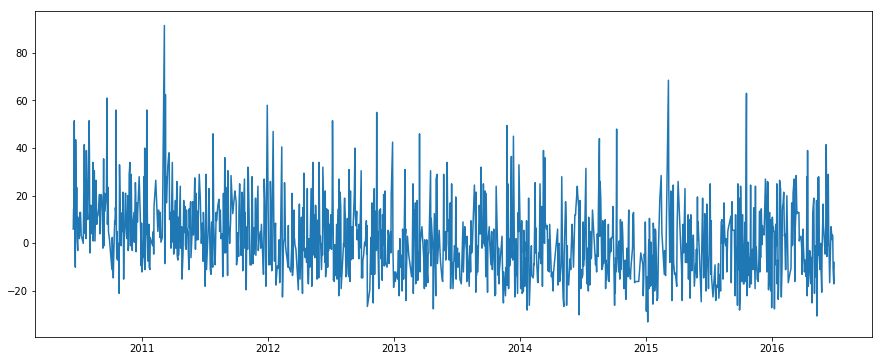

In [14]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear'),'date']
y = data.loc[(data['cloud.indicator']=='clear'),'car.count_substracted']
plt.plot(x,y)

In [15]:
data['count_consecutive_cloud.indicator'] = data.groupby((data['cloud.indicator'] != data['cloud.indicator'].shift(1)).cumsum()).cumcount()+1

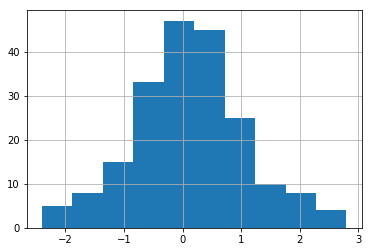

In [16]:
data[data['cloud.indicator']=='cloudy'].sort_values('car.count_substracted',ascending=False)[-200:]['weather'].hist()

## Does having a lot of back to back clear or cloudy days increase values?

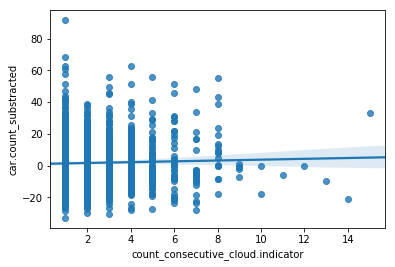

In [17]:
ax = sns.regplot(x='count_consecutive_cloud.indicator', y="car.count_substracted", data=data[data['cloud.indicator']=='clear'])

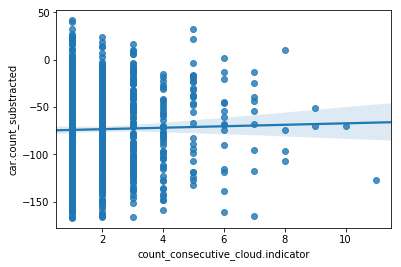

In [18]:
ax = sns.regplot(x='count_consecutive_cloud.indicator', y="car.count_substracted", data=data[data['cloud.indicator']=='cloudy'])

## Cloud indicator vs car count

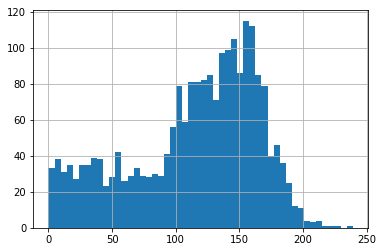

In [19]:
data['car.count'].hist(bins=50)

In [20]:
data['cloud.indicator'].unique()

array(['clear', 'cloudy'], dtype=object)

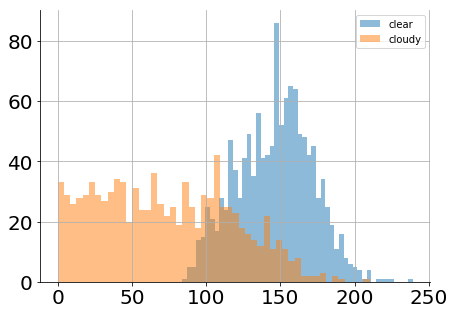

In [21]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[data['cloud.indicator']=='clear','car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[data['cloud.indicator']=='cloudy','car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

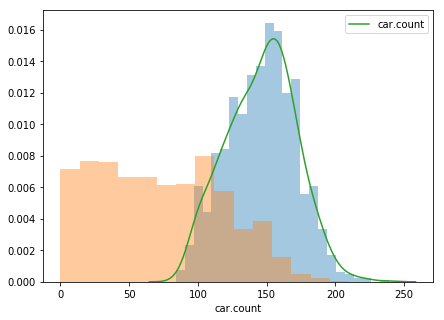

In [22]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
sns.distplot(data.loc[data['cloud.indicator']=='clear','car.count'],norm_hist=True,ax=ax,kde=False)
sns.distplot(data.loc[data['cloud.indicator']=='cloudy','car.count'],norm_hist=True,ax=ax,kde=False)
sns.kdeplot(data.loc[data['cloud.indicator']=='clear','car.count'],ax=ax,kernel='gau')

Clearly the distribution of car counts are very different if we have a cloudy day.

## Day of the week and month of the year vs car_count

(40, 100)

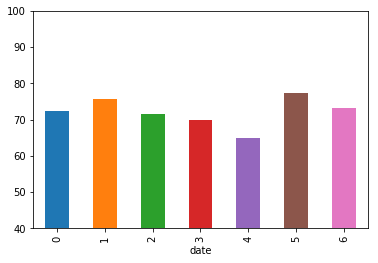

In [23]:
data[data['cloud.indicator']=='cloudy'].groupby(pd.to_datetime(data['date']).dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

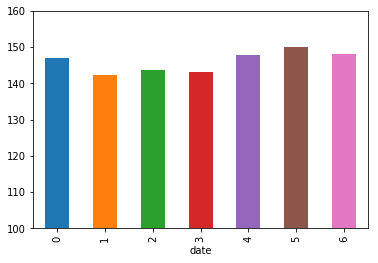

In [24]:
data[data['cloud.indicator']=='clear'].groupby(pd.to_datetime(data['date']).dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((100,160))

(100, 160)

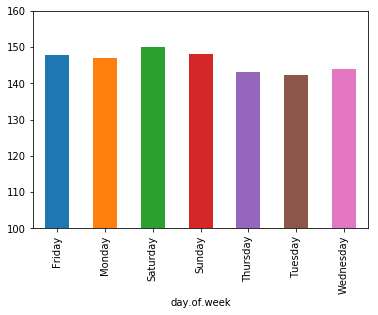

In [25]:
data[data['cloud.indicator']=='clear'].groupby('day.of.week')['car.count'].mean().plot.bar()
plt.ylim((100,160))

There doesn't seem to be a strong variation between weekdays

In [26]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,indicator_change,100_moving_ave,car.count_substracted,count_consecutive_cloud.indicator
0,2010-06-17,Thursday,119,0.7,clear,June,2010,3,1.0,113.0,6.0,1
1,2010-06-18,Friday,128,1.3,clear,June,2010,3,-0.0,113.5,14.5,2
2,2010-06-19,Saturday,128,-0.8,clear,June,2010,3,-0.0,114.5,13.5,3
3,2010-06-20,Sunday,166,-0.9,clear,June,2010,3,-0.0,114.5,51.5,4
4,2010-06-21,Monday,123,0.0,clear,June,2010,3,-0.0,115.0,8.0,5


(40, 100)

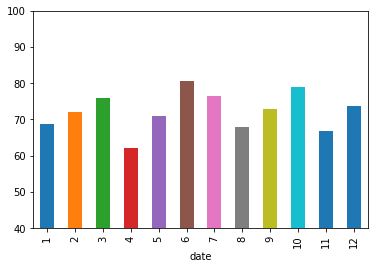

In [27]:
data[data['cloud.indicator']=='cloudy'].groupby(pd.to_datetime(data['date']).dt.month)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

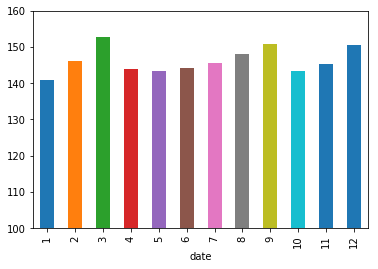

In [28]:
data[data['cloud.indicator']=='clear'].groupby(pd.to_datetime(data['date']).dt.month)['car.count'].mean().plot.bar()
plt.ylim((100,160))

(100, 160)

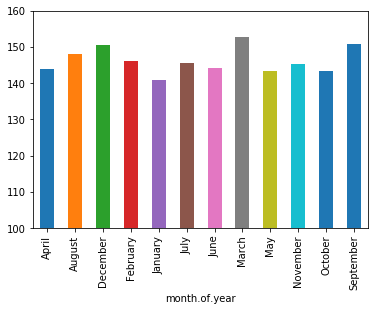

In [29]:
data[data['cloud.indicator']=='clear'].groupby('month.of.year')['car.count'].mean().plot.bar()
plt.ylim((100,160))

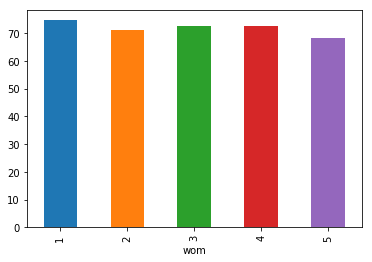

In [30]:
data[data['cloud.indicator']=='cloudy'].groupby('wom')['car.count'].mean().plot.bar()

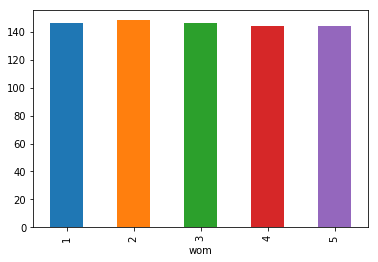

In [31]:
data[data['cloud.indicator']=='clear'].groupby('wom')['car.count'].mean().plot.bar()

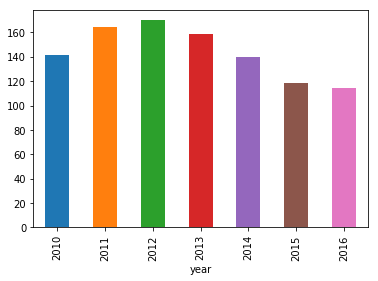

In [32]:
data[data['cloud.indicator']=='clear'].groupby('year')['car.count'].mean().plot.bar()
#plt.ylim((100,160))

Most likely there is recovery after financial crisis followed by retail apocalypse

## Weather vs car_count

In [33]:
data['weather'].unique()

array([ 0.7,  1.3, -0.8, -0.9,  0. , -0.5, -0.4, -0.1, -1. ,  0.6,  0.3,
       -1.7,  0.4, -0.3, -0.6,  0.8, -1.2,  1.8, -0.7, -1.8,  1.7,  1. ,
       -0.2,  1.2, -2.3, -1.1, -1.6,  0.2,  3.8,  0.9,  1.1,  2.6, -2. ,
        1.9,  1.5, -1.4, -2.7,  1.4,  0.1,  2. ,  0.5, -2.4,  3.2, -2.1,
       -1.3, -1.5, -2.9,  2.1,  1.6,  2.4, -1.9,  2.3,  2.2, -2.5,  2.5,
       -3. , -2.2,  2.7,  4.3,  3.1, -3.2,  3. ,  2.8, -3.1, -2.6,  3.3])

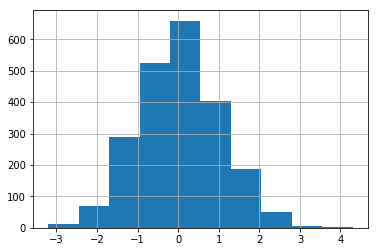

In [34]:
data['weather'].hist()

Looks like weather is a standard normal distribution

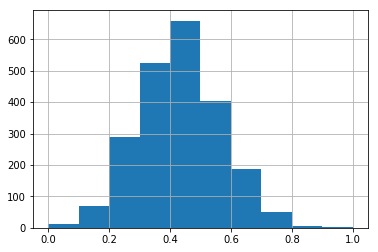

In [35]:
pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['weather'].values.reshape(-1, 1))[:,0],name='weather').hist()

### Is there a relationship between car.count and weather?

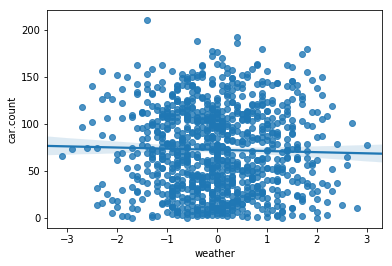

In [36]:
ax = sns.regplot(x="weather", y="car.count", data=data[data['cloud.indicator']=='cloudy'])

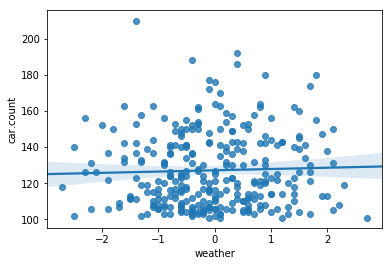

In [37]:
ax = sns.regplot(x="weather", y="car.count", data=data[(data['cloud.indicator']=='cloudy')&(data['car.count']>100)])

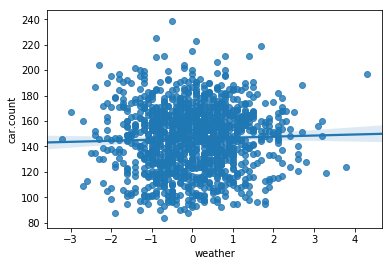

In [38]:
ax = sns.regplot(x="weather", y="car.count", data=data[data['cloud.indicator']=='clear'])

In [39]:
from scipy.stats import linregress
x = data.loc[data['cloud.indicator']=='clear','weather']
y = data.loc[data['cloud.indicator']=='clear','car.count']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

0.82337038353 146.07433429 0.0331654636288 0.24055430192 0.70124216531


In [40]:
x = data.loc[data['cloud.indicator']=='cloudy','weather']
y = data.loc[data['cloud.indicator']=='cloudy','car.count']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

-1.23270004 72.2733259557 -0.0277542108396 0.392339750095 1.44045399403


There doesn't seem to be an significant relationship between weather and car count

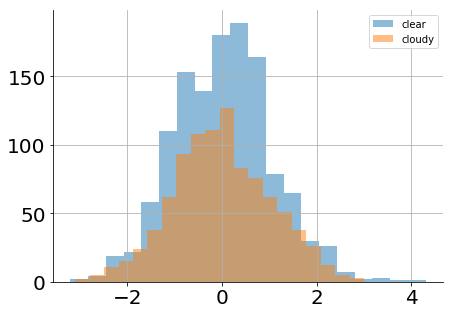

In [41]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='clear'),'weather'].hist(bins=20,ax=ax,label='clear',alpha=0.5)
data.loc[(data['cloud.indicator']=='cloudy'),'weather'].hist(bins=20,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

## Time vs car_count

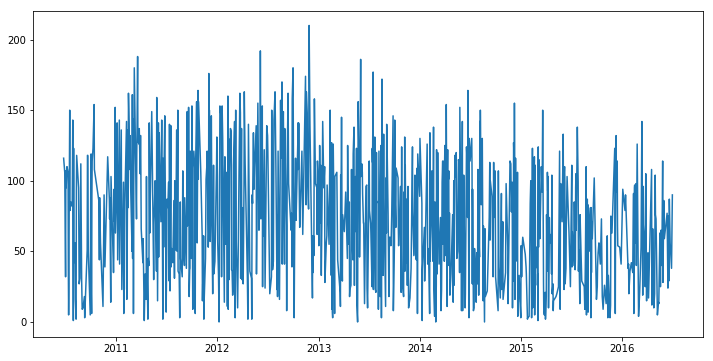

In [42]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='cloudy','date']
y = data.loc[data['cloud.indicator']=='cloudy','car.count']
plt.plot(x,y)

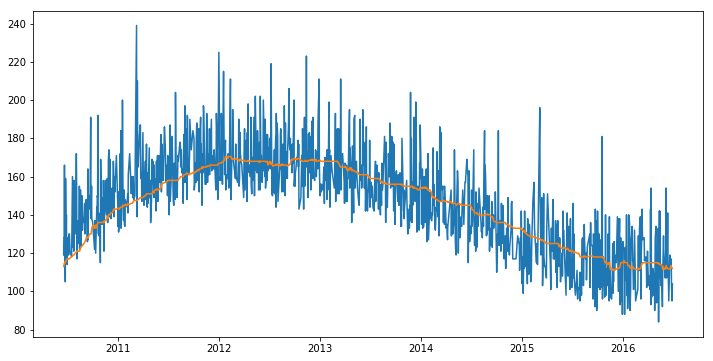

In [43]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='clear','date']
y = data.loc[data['cloud.indicator']=='clear','car.count']
plt.plot(x,y)
plt.plot(x,data.loc[data['cloud.indicator']=='clear','100_moving_ave'])

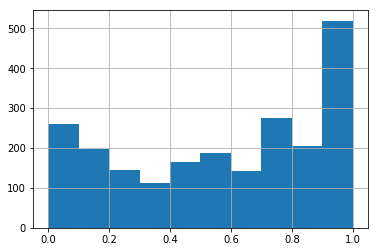

In [44]:
pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave'].values.reshape(-1, 1))[:,0],name='100_day_ave').hist()

# Are there oscillations within years?

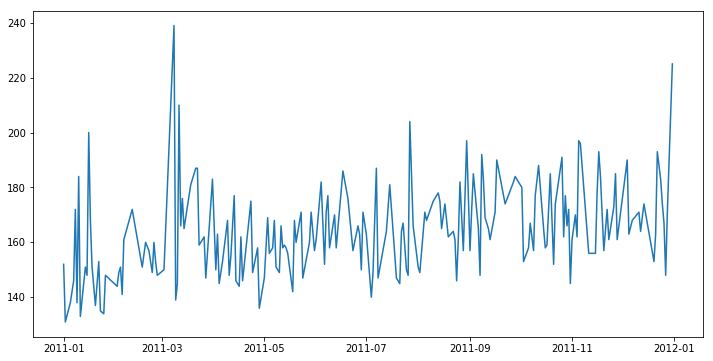

In [45]:
plt.figure(figsize=(12,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2011),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2011),'car.count']
plt.plot(x,y)

# Could indicator change be a reason for spikes?

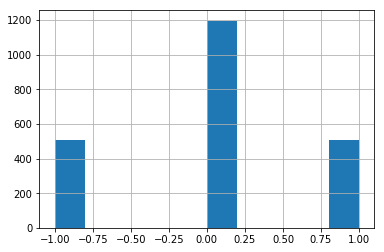

In [46]:
data['indicator_change'].hist()

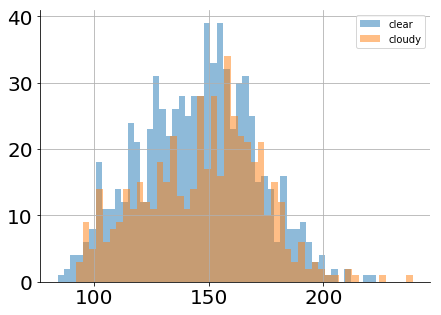

In [47]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='clear')&(data['indicator_change']==0),'car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[(data['cloud.indicator']=='clear')&(data['indicator_change']==1),'car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

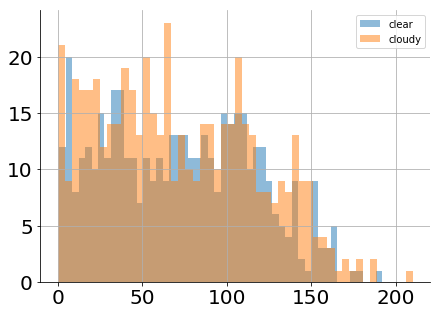

In [48]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='cloudy')&(data['indicator_change']==0),'car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[(data['cloud.indicator']=='cloudy')&(data['indicator_change']==-1),'car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

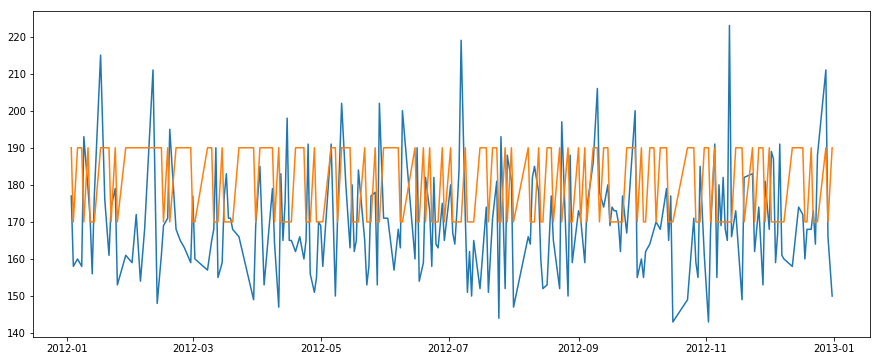

In [49]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'car.count']
z = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'indicator_change']
z = z*20+170
plt.plot(x,y)
plt.plot(x,z)

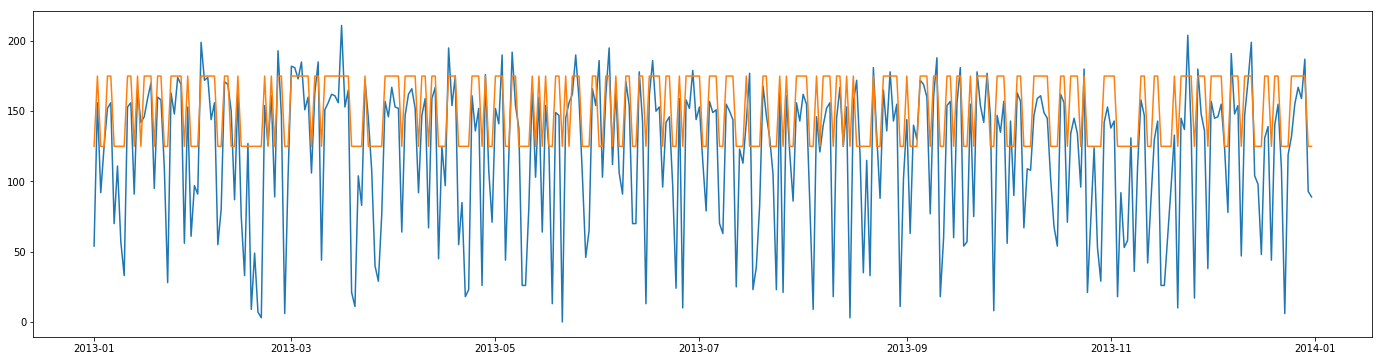

In [50]:
plt.figure(figsize=(24,6))
x = data.loc[(pd.to_datetime(data['date']).dt.year==2013),'date']
y = data.loc[(pd.to_datetime(data['date']).dt.year==2013),'car.count']
z = data.loc[(pd.to_datetime(data['date']).dt.year==2013),'cloud.indicator'].factorize()[0]
z = z*50+125
plt.plot(x,y)
plt.plot(x,z)


<a id='cell2'></a>
# Linear Regression

### Preprocessing steps for Linear Regression

In [51]:
X = pd.concat([pd.get_dummies(data[['day.of.week','month.of.year']]),
               pd.get_dummies(data['indicator_change'].astype(str)),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
              data[['car.count','date']],
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['weather'].values.reshape(-1, 1))[:,0],name='weather'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave'].values.reshape(-1, 1))[:,0],name='100_moving_ave'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['count_consecutive_cloud.indicator'].values.reshape(-1, 1))[:,0],name='count_consecutive_cloud.indicator')],
              axis=1)
X.head()

/home/eminozkan/.conda/envs/challenge/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,day.of.week_Friday,day.of.week_Monday,day.of.week_Saturday,day.of.week_Sunday,day.of.week_Thursday,day.of.week_Tuesday,day.of.week_Wednesday,month.of.year_April,month.of.year_August,month.of.year_December,...,month.of.year_September,-0.0,-1.0,1.0,cloud.indicator,car.count,date,weather,100_moving_ave,count_consecutive_cloud.indicator
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,119,2010-06-17,0.520000,0.033613,0.000000
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,128,2010-06-18,0.600000,0.042017,0.071429
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,128,2010-06-19,0.320000,0.058824,0.142857
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,166,2010-06-20,0.306667,0.058824,0.214286
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,123,2010-06-21,0.426667,0.067227,0.285714


In [52]:
X.isnull().values.any()


False

In [53]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2015,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

(1659, 28) (546, 28)


In [54]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Ridge regression

In [55]:
from sklearn.linear_model import Ridge

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = Ridge(alpha=10.0, 
            fit_intercept=True, 
            normalize=False, 
            copy_X=True, 
            max_iter=None, 
            tol=0.001, solver='auto', random_state=None)
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score for the mean model',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.608512390341
explained_variance_score 0.320644939106
explained_variance_score for the mean model 0.0
mean_absolute_error 23.957555084
mean_absolute_percentage_error 26.5360138164
mean_absolute_percentage_error for the mean model 35.1221158617


In [56]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score for the mean model',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.469426619451
explained_variance_score 0.489927873637
explained_variance_score for the mean model -7.85816227532e+30
mean_absolute_error 23.7168813175
mean_absolute_percentage_error 30.6470424766
mean_absolute_percentage_error for the mean model 35.3861457353


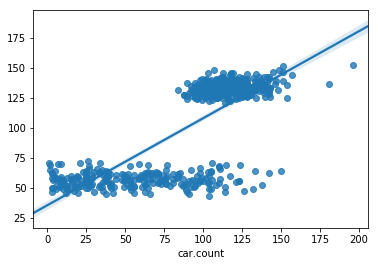

In [57]:
ax = sns.regplot(x=y_true, y=y_pred)

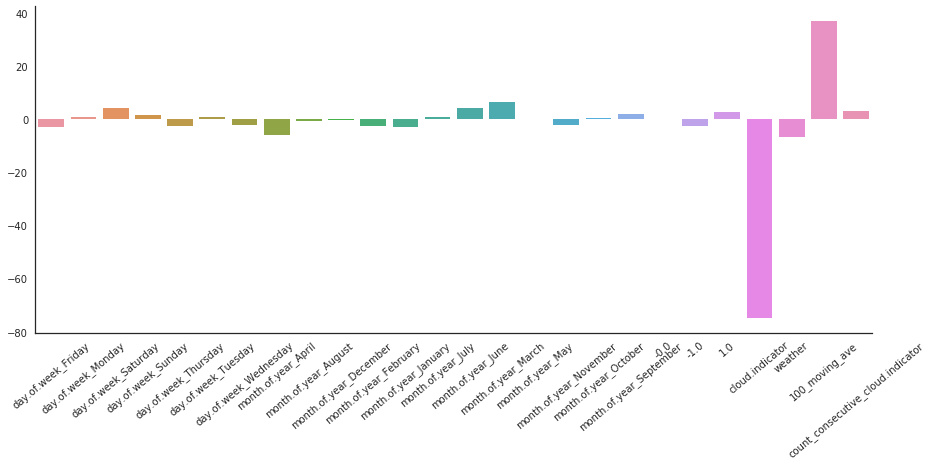

In [58]:
plt.figure(figsize=(15,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

# Lasso

In [59]:
from sklearn.linear_model import Lasso

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = Lasso(alpha=1, fit_intercept=True, 
            normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, 
            warm_start=False, positive=False, random_state=None, selection='cyclic')
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.593703200611
explained_variance_score 0.221433642713
explained_variance_score 0.0
mean_absolute_error 24.749711329
mean_absolute_percentage_error 26.6583666188
mean_absolute_percentage_error for the mean model 35.1221158617


In [60]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.314645772098
explained_variance_score 0.463260794339
explained_variance_score -7.85816227532e+30
mean_absolute_error 28.448083555
mean_absolute_percentage_error 30.4677442233
mean_absolute_percentage_error for the mean model 35.3861457353


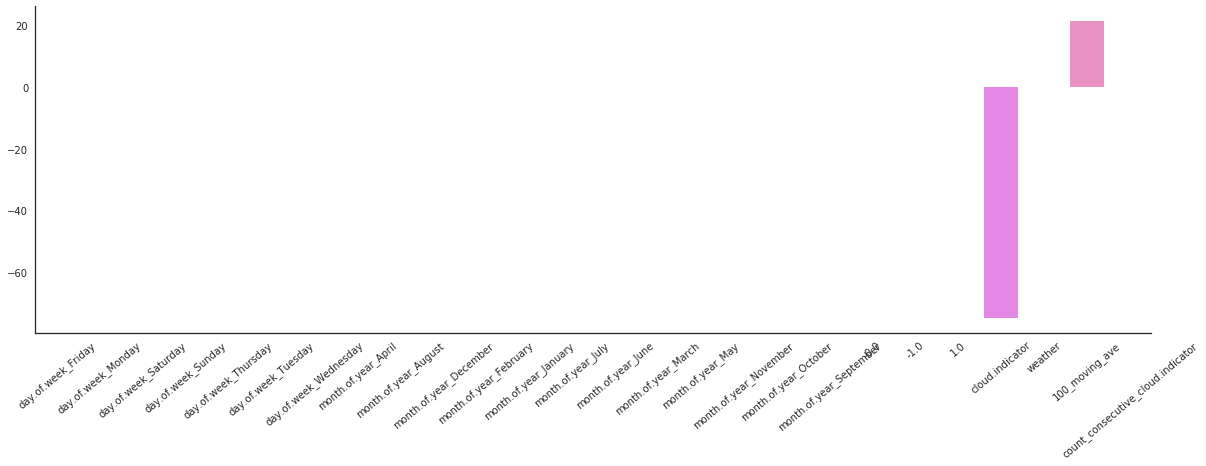

In [61]:
plt.figure(figsize=(20,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

<a id='cell3'></a>

# Neural Network

In [62]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout, Flatten, Dense,BatchNormalization, GaussianNoise, Activation
from keras import optimizers



train_set = X_train.drop(['date','car.count'],axis=1)
train_labels = X_train['car.count']
valid_set = X_valid.drop(['date','car.count'],axis=1)
valid_labels = X_valid['car.count']


# Create the model
model = Sequential()
model.add(Dense(28, input_shape=x.shape[1:]))
model.add(Dense(28, activation='relu'))
model.add(Dense(1, name='three'))
model.summary()

rms_optimizer = optimizers.RMSprop(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=rms_optimizer)

weight_file = 'weights.best.hdf5'

checkpointer = ModelCheckpoint(filepath=weight_file,
                               verbose=1, save_best_only=True)

model.fit(train_set, train_labels,
                 validation_data=(valid_set, valid_labels),
                 epochs=5, batch_size=1024,
                 callbacks=[checkpointer], verbose=2)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28)                756       
_________________________________________________________________
dense_2 (Dense)              (None, 28)                812       
_________________________________________________________________
three (Dense)                (None, 1)                 29        
Total params: 1,597
Trainable params: 1,597
Non-trainable params: 0
_________________________________________________________________
Train on 1659 samples, validate on 546 samples
Epoch 1/5
Epoch 00001: val_loss improved from inf to 9460.38477, saving model to weights.best.hdf5
 - 0s - loss: 17286.8726 - val_loss: 9460.3848
Epoch 2/5
Epoch 00002: val_loss improved from 9460.38477 to 8120.61084, saving model to weights.best.hdf5
 - 0s - loss: 16131.0270 - val_loss: 8120.6108
Epoch 3/5
Epoch 00003: val_loss improved from 8120.61084 t

In [63]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
model.load_weights(weight_file)
y_pred =  model.predict(valid_set)[:,0]
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.314645772098
explained_variance_score -72.0125931638
explained_variance_score -7.85816227532e+30
mean_absolute_error 48.813288266
mean_absolute_percentage_error 84.9586454483
mean_absolute_percentage_error for the mean model 35.3861457353


<a id='cell4'></a>

# Decision tree regression

In [64]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,indicator_change,100_moving_ave,car.count_substracted,count_consecutive_cloud.indicator
0,2010-06-17,Thursday,119,0.7,clear,June,2010,3,1.0,113.0,6.0,1
1,2010-06-18,Friday,128,1.3,clear,June,2010,3,-0.0,113.5,14.5,2
2,2010-06-19,Saturday,128,-0.8,clear,June,2010,3,-0.0,114.5,13.5,3
3,2010-06-20,Sunday,166,-0.9,clear,June,2010,3,-0.0,114.5,51.5,4
4,2010-06-21,Monday,123,0.0,clear,June,2010,3,-0.0,115.0,8.0,5


## Preprocessing steps for decision tree regression

In [65]:
X = pd.concat([pd.Series(data['month.of.year'].factorize()[0],name='month.of.year'),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
               pd.Series(data['day.of.week'].factorize()[0],name='day.of.week'),
              data[['car.count','date','weather','100_moving_ave','count_consecutive_cloud.indicator','indicator_change']]],axis=1)
X.head()

,month.of.year,cloud.indicator,day.of.week,car.count,date,weather,100_moving_ave,count_consecutive_cloud.indicator,indicator_change
0,0,0,0,119,2010-06-17,0.7,113.0,1,1.0
1,0,0,1,128,2010-06-18,1.3,113.5,2,-0.0
2,0,0,2,128,2010-06-19,-0.8,114.5,3,-0.0
3,0,0,3,166,2010-06-20,-0.9,114.5,4,-0.0
4,0,0,4,123,2010-06-21,0.0,115.0,5,-0.0


In [66]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2015,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

(1659, 9) (546, 9)


In [67]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train.drop(['date','car.count'],axis=1),  X_train['car.count'])

lgb_eval = lgb.Dataset(X_valid.drop(['date','car.count'],axis=1),  X_valid['car.count'])

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mean_squared_error'},
    #'num_leaves': 8,
    'learning_rate': 0.1,
    'verbose': 50
}
print('Start training...')
# train
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                evals_result=evals_result,
                early_stopping_rounds=1)

Start training...
[1]	valid_0's l2: 2193.41
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's l2: 1968.9
[3]	valid_0's l2: 1792.51
[4]	valid_0's l2: 1637.3
[5]	valid_0's l2: 1528.92
[6]	valid_0's l2: 1447.11
[7]	valid_0's l2: 1375.81
[8]	valid_0's l2: 1309.51
[9]	valid_0's l2: 1253.54
[10]	valid_0's l2: 1190.35
[11]	valid_0's l2: 1154.03
[12]	valid_0's l2: 1129.92
[13]	valid_0's l2: 1095.61
[14]	valid_0's l2: 1081.02
[15]	valid_0's l2: 1062.03
[16]	valid_0's l2: 1051.09
[17]	valid_0's l2: 1023.53
[18]	valid_0's l2: 1007.52
[19]	valid_0's l2: 992.723
[20]	valid_0's l2: 988.117
[21]	valid_0's l2: 976.862
[22]	valid_0's l2: 969.337
[23]	valid_0's l2: 964.007
[24]	valid_0's l2: 964.481
Early stopping, best iteration is:
[23]	valid_0's l2: 964.007


In [68]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = gbm.predict(x, num_iteration=gbm.best_iteration)
print('R2',r2_score(y_true,y_pred)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

R2 0.392538561199
explained_variance_score 0.237273376397
explained_variance_score -1.96454056883e+30
mean_absolute_error 25.2319903684
mean_absolute_percentage_error 27.713252223
mean_absolute_percentage_error for the mean model 35.3861457353


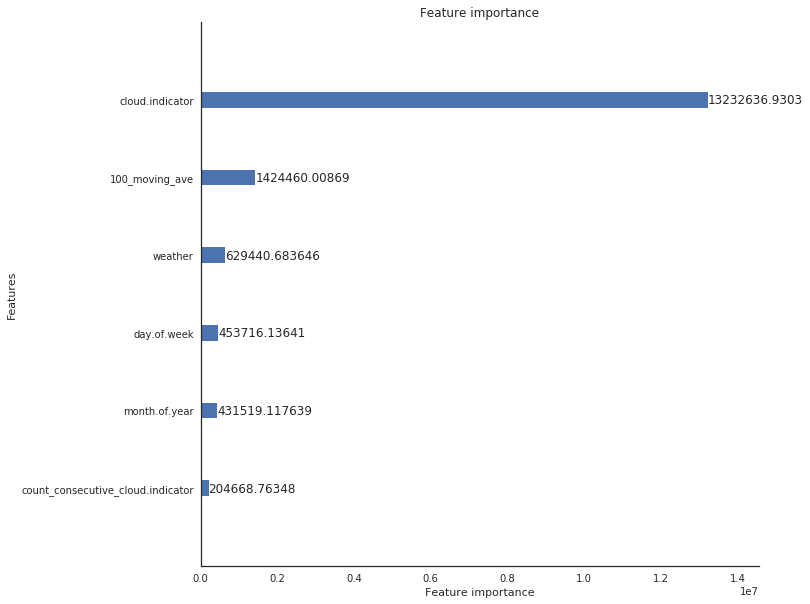

In [69]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='gain')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

# Conclusion:

I started by making sure that there are no missing values and the data is sorted on date. This is pretty important for time-series data. After EDA, I found that having a cloudy day impairs having an accurate estimate of car counts. There are weak variations in car counts depending on the day of the week or month of the year. I also did not find a correlation between weather and car counts. There was however strong long term trends when looking at years seperately, with the highest amount of cars present in 2012. I also constructed models in order to predict feature values of car counts. My initial models were really bad. However by including a 100 day moving median, I was able to capture long-term trends, and this significantly improved my models. I was able to obtain R2 value of around 0.4 in the validation data, which is not great, but it shows that we have a significant imporevement compared to a mean model. Looking for coefficients of both linear models and non-linear models we can see that the most important coefficient is cloud_indicator, and this makes sense. If it is cloudy there are less cars. The second most important coefficient is 100-day moving average, and the other coefficients have a very small role in terms of being able to predict the number of car counts.

Given more time I would:

1) Tune models; for example find the best regularization coefficients.
2) Try to work on identifying outliers by doing someting like bollinger bands or RSI (this was a question in my phone talk with Steve).
3) Include week of the month and see if this imporves the model (I doubt it)
4) Engineer another feature such as how many days back to back it was cloudy and clear etc. It could be that having a lot of cloudy or clear days together may change people's mood and they may visit a store more or less.